In [18]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

patient_id = 31
mn_ratio = 30
fp_ratio = 15
lr = 0.05

In [19]:
# Format data
embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'

with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

patient_embeddings = patient_data['patient_embeddings'] # (num_files, 32, 512)
print('patient_embeddings shape: ', patient_embeddings.shape)
flat_embeddings = patient_embeddings.reshape(-1, patient_embeddings.shape[-1])
print('flat_embeddings shape: ', flat_embeddings.shape)

# Load sleep metadata
sleep_data = pd.read_excel('metadata/cleaned_sleep.xlsx')

# Convert datetime columns
sleep_data['OnsetDatetime'] = pd.to_datetime(sleep_data['OnsetDatetime'])
sleep_data['OffsetDatetime'] = pd.to_datetime(sleep_data['OffsetDatetime'])

patient_embeddings shape:  (640, 32, 512)
flat_embeddings shape:  (20480, 512)


In [28]:
# Set up sleep tagging functions

def find_sleep_stage(start_time, stop_time, sleep_data, patient_id, certainty_threshold):
    """Find sleep stage for a given time window and patient."""
    patient_sleep = sleep_data[
        (sleep_data['PatID'] == patient_id) & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    if len(patient_sleep) == 0:
        return 'unknown'
    
    # Check for overlapping sleep stages
    overlapping_stages = patient_sleep[
        (patient_sleep['OnsetDatetime'] <= stop_time) & 
        (patient_sleep['OffsetDatetime'] >= start_time)
    ]
    
    if len(overlapping_stages) > 0:
        sleep_stage = overlapping_stages.iloc[0]['SleepCat']
        # Group N2 and N3 into N
        return 'N' if sleep_stage in ['N2', 'N3'] else sleep_stage
    return 'unknown'

def tag_points(patient_id, sleep_data, certainty_threshold):
    """Tag points with sleep stage metadata and update patient's data."""
    print("Tagging patient data with sleep metadata...")
    embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'

    with open(embedding_path, 'rb') as f:
        data = pickle.load(f)
    
    print("\nProcessing patient data...")
    
    # Get this patient's sleep metadata
    pat_sleep = sleep_data[
        (sleep_data['PatID'] == f"Epat{patient_id}") & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    # Get number of files from the embeddings shape
    n_files = data['patient_embeddings'].shape[0]
    print(f"Number of files for patient {patient_id}: {n_files}")
    
    if len(pat_sleep) == 0:
        print(f"No sleep events found for Epat{patient_id}")
        # Tag all points as unknown for this patient
        sleep_stages = ['unknown'] * (n_files * 32)  # 32 windows per file
        print(f"Added {len(sleep_stages)} 'unknown' labels")
    else:
        print(f"Found {len(pat_sleep)} sleep events")
        # Tag each window for this patient
        sleep_stages = []
        file_start_times = data['start_times']
        
        for file_idx, file_start in enumerate(file_start_times):
            # Calculate window start times for this file
            window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
            window_ends = [start + pd.Timedelta(seconds=60) for start in window_starts]  # 60-second windows
            
            # Tag each window
            for window_start, window_end in zip(window_starts, window_ends):
                stage = find_sleep_stage(window_start, window_end, sleep_data, f"Epat{patient_id}", certainty_threshold)
                sleep_stages.append(stage)
        
        print(f"Added {len(sleep_stages)} labels")
    
    # Print summary statistics
    stage_counts = pd.Series(sleep_stages).value_counts()
    print("\nSleep stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count}")
    
    # Update sleep_labels in data
    data['sleep_labels'] = sleep_stages
    print("\nSleep labels shape:", len(data['sleep_labels']))
    print("Patient embeddings shape:", data['patient_embeddings'].shape)
    
    # Save updated data back to file
    print("\nSaving updated patient data...")
    with open(embedding_path, 'wb') as f:
        pickle.dump(data, f)

In [40]:
tag_points(patient_id, sleep_data, 0.6)

# Reload the updated data
embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
with open(embedding_path, 'rb') as f:
    patient_data = pickle.load(f)

sleep_labels = patient_data['sleep_labels']
print("Sleep labels shape:", len(sleep_labels))

Tagging patient data with sleep metadata...

Processing patient data...
Number of files for patient 31: 640
Found 14 sleep events
Added 20480 labels

Sleep stage distribution:
unknown: 19695
N: 404
W: 332
R: 49

Sleep labels shape: 20480
Patient embeddings shape: (640, 32, 512)

Saving updated patient data...
Sleep labels shape: 20480


In [42]:
print(sleep_labels)

['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'

In [33]:
pacmap_params = {
    'n_components': 2,
    'MN_ratio': 30,
    'FP_ratio': 15,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=300, n_FP=150, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((204800, 2), (6144000, 2), (3072000, 2))
Initial Loss: 2179189.0
Iteration:   10, Loss: 1965310.750000
Iteration:   20, Loss: 1783262.500000
Iteration:   30, Loss: 1686022.375000
Iteration:   40, Loss: 1597126.875000
Iteration:   50, Loss: 1510536.000000
Iteration:   60, Loss: 1377634.500000
Iteration:   70, Loss: 1240971.250000
Iteration:   80, Loss: 1087120.625000
Iteration:   90, Loss: 881015.750000
Iteration:  100, Loss: 562100.750000
Iteration:  110, Loss: 453931.937500
Iteration:  120, Loss: 396387.187500
Iteration:  130, Loss: 362848.937500
Iteration:  140, Loss: 341869.750000
Iteration:  150, Loss: 327346.656250
Iteration:  160, Loss: 316697.406250
Iteration:  170

Plotting 332 points for W
Plotting 404 points for N
Plotting 49 points for R


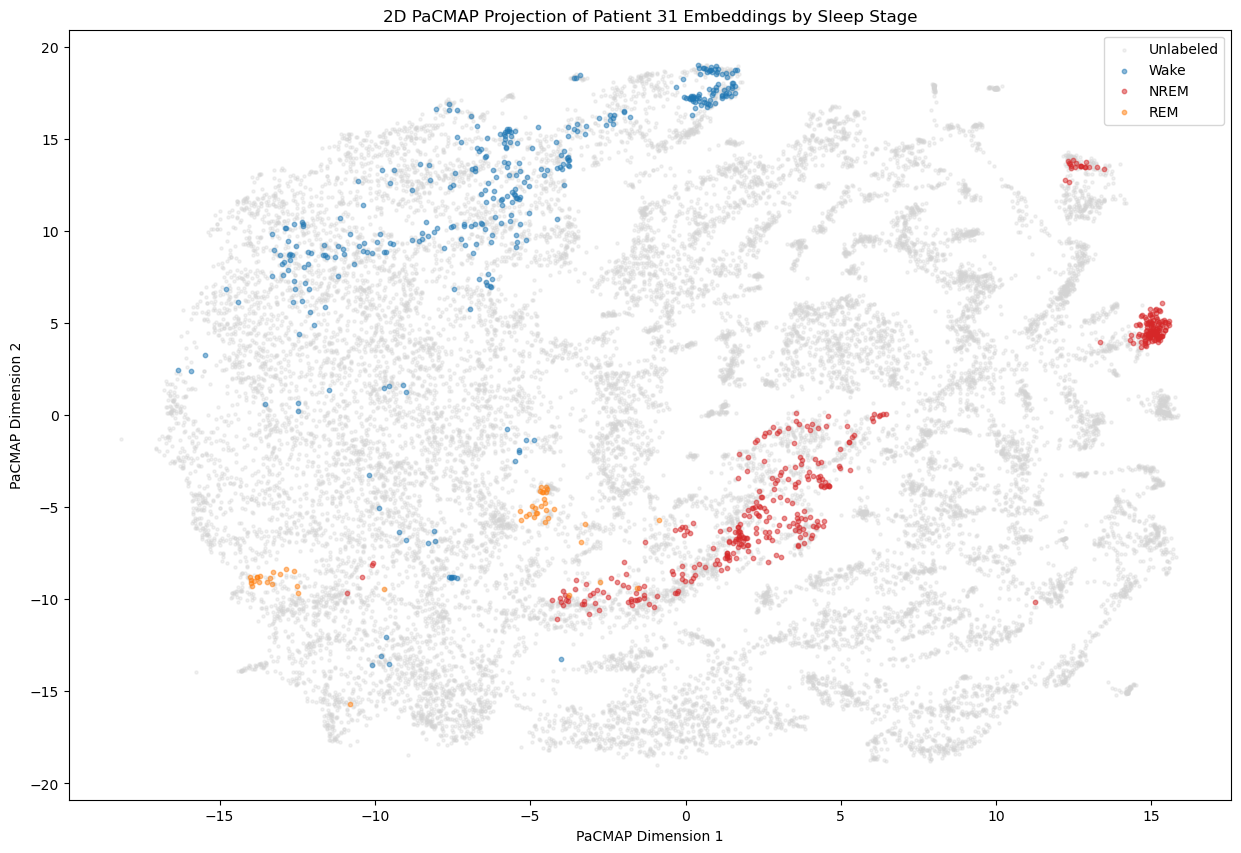

In [46]:
# Plot results
plt.figure(figsize=(15,10))

# Plot unlabeled points in grey first
labeled_mask = np.isin(sleep_labels, ['W', 'N', 'R'])
plt.scatter(manifold_2d[~labeled_mask,0], manifold_2d[~labeled_mask,1],
           c='lightgray', alpha=0.3, s=5, label='Unlabeled')

# Define color and label mappings
sleep_colors = {
    'W': '#1f77b4',  # Wake - blue
    'N': '#d62728',  # NREM - red
    'R': '#ff7f0e'   # REM - orange
}
sleep_names = {
    'W': 'Wake',
    'N': 'NREM',
    'R': 'REM'
}

# Plot labeled points on top
for label in sleep_colors:
    mask = np.array(sleep_labels) == label  # Convert to numpy array for boolean indexing
    if np.any(mask):  # Only plot if there are any points with this label
        plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
                   c=sleep_colors[label],
                   label=sleep_names[label],
                   alpha=0.5, s=10)
        print(f"Plotting {np.sum(mask)} points for {label}")  # Debug print

plt.title(f'2D PaCMAP Projection of Patient {patient_id} Embeddings by Sleep Stage')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()